# Analyzing Labor Market Impacts: Miami vs. Comparison Cities (1979-1985)

## Project Overview

This project examines labor market outcomes in Miami, Florida, compared to a set of similar metropolitan areas, during a period marked by a significant influx of Cuban immigrants (the Mariel Boatlift in 1980). We will use a pre-aggregated dataset (`card85.txt`) containing yearly summary statistics for different demographic groups.

The analysis focuses on replicating key tables and figures often presented in studies of this event, specifically looking at:
1.  Demographic characteristics in Miami at the start of the period (1979).
2.  Trends in average log real hourly earnings over time (1979-1985).
3.  Trends in unemployment rates over time (1979-1985).
4.  Trends in weekly earnings and hours worked.

The comparison cities used in the aggregation process (though not explicitly listed in `card85.txt`) typically include Atlanta, Houston, Los Angeles, and Tampa-St. Petersburg, chosen for their similar labor market characteristics prior to 1980.

## Data Source

*   `card85.txt`: A text file containing aggregated yearly data. Each row represents a specific demographic group within a location (Miami or Comparison Cities) for a given year.
*   https://davidcard.berkeley.edu/papers/mariel-impact.pdf

## Key Variables in `card85.txt`

*   `year`: Survey year (1979-1985)
*   `miami`: Indicator variable (1 = Miami, 0 = Comparison Cities)
*   `group`: Numeric code for demographic group (1=White, 2=Black, 3=Other Non-Hispanic, 4=Cuban, 5=Hispanic non-Cuban)
*   `count`: Raw sample count for the group-year-location cell.
*   `pop`: Estimated population represented by the cell.
*   `grade`: Average years of schooling.
*   `n_unem`, `pop_unem`: Sample count and estimated population of unemployed individuals.
*   `n_emp`, `pop_emp`: Sample count and estimated population of employed individuals.
*   `urate`: Calculated unemployment rate (`pop_unem` / (`pop_unem` + `pop_emp`)).
*   `n_earn`, `pop_earn`: Sample count and estimated population of earners.
*   `log_earn`: Average natural logarithm of real hourly earnings (deflated to 1980 dollars).
*   `earnwk`: Average real weekly earnings.
*   `uhours`: Average usual weekly hours worked.

## Step 1: Setup - Import Libraries

We need libraries for data manipulation (`pandas`), numerical operations (`numpy`), and plotting (`matplotlib`, `seaborn`).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configure plot styles
sns.set_theme(style="whitegrid")
# Ensure plots appear within the notebook
# %matplotlib inline # Uncomment if running in a standard Jupyter environment
# Suppress potential warnings (optional)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

## Step 2: Load the Aggregated Data

We load the `card85.txt` file into a pandas DataFrame. The file uses spaces as delimiters.

In [4]:
# Define the path to the data file
file_path = 'card85.txt'

# Attempt to load the data
try:
    # Use '\s+' regex for one or more spaces as delimiter
    df = pd.read_csv(file_path, sep='\s+')
    print("Data loaded successfully.")
    print(f"Shape of the DataFrame: {df.shape}")
    print("\nFirst 5 rows:")
    display(df.head())
    print("\nData types and non-null counts:")
    df.info()
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please ensure the file is in the correct directory.")
    df = None # Set df to None if loading fails
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    df = None

# Stop execution if data loading failed
if df is None:
     raise SystemExit("Stopping execution: Data could not be loaded.")

Data loaded successfully.
Shape of the DataFrame: (66, 16)

First 5 rows:


<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/dd/h93zssnj4z16y7nnmv_h9f3r0000gn/T/ipykernel_22761/1435326033.py:7: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+')


,year,miami,group,count,pop,grade,n_unem,pop_unem,n_emp,pop_emp,urate,n_earn,pop_earn,log_earn,earnwk,uhours
1,1979,0,1,8283,4.994680e+06,12.901162,288,168988.617676,6065,3.660157e+06,4.413220,5378,3.254866e+06,1.931840,323.848992,39.421532
2,1979,0,2,1876,1.149539e+06,11.830627,139,81748.722310,1149,7.142293e+05,10.270224,1093,6.802461e+05,1.743386,247.200708,38.906679
3,1979,0,3,627,3.847314e+05,13.488459,23,14481.095093,456,2.821881e+05,4.881227,409,2.546116e+05,1.865677,295.355288,38.938875
4,1979,0,4,61,3.589159e+04,11.914719,5,2935.910807,38,2.248789e+04,11.547885,34,2.046308e+04,1.841521,282.706802,37.764706
5,1979,0,5,2399,1.438610e+06,9.332750,109,63389.674215,1613,9.705136e+05,6.131103,1514,9.129091e+05,1.673218,236.190280,39.359974



Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 1 to 66
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      66 non-null     int64  
 1   miami     66 non-null     int64  
 2   group     66 non-null     int64  
 3   count     66 non-null     int64  
 4   pop       66 non-null     float64
 5   grade     66 non-null     float64
 6   n_unem    66 non-null     int64  
 7   pop_unem  66 non-null     float64
 8   n_emp     66 non-null     int64  
 9   pop_emp   66 non-null     float64
 10  urate     66 non-null     float64
 11  n_earn    66 non-null     int64  
 12  pop_earn  66 non-null     float64
 13  log_earn  66 non-null     float64
 14  earnwk    66 non-null     float64
 15  uhours    66 non-null     float64
dtypes: float64(9), int64(7)
memory usage: 8.8 KB


## Step 3: Data Preparation

To make the analysis clearer, we will:
1.  Rename the numeric `group` column to `group_code` to avoid confusion.
2.  Create a new categorical `group_name` column with descriptive labels.
3.  Split the data into two subsets: one for Miami and one for the Comparison Cities.
4.  For many analyses (like Tables 3 & 4, and plots), the 'Other' group (code 3) is often excluded. We will create filtered datasets for this purpose.

In [5]:
# 1. Rename 'group' to 'group_code'
df = df.rename(columns={'group': 'group_code'})

# 2. Create 'group_name' column
group_mapping = {
    1: "White",
    2: "Black",
    3: "Other",
    4: "Cuban",
    5: "Hispanic" # Non-Cuban Hispanics
}
df['group_name'] = df['group_code'].map(group_mapping)

# 3. Split data by location
miami_df_full = df[df['miami'] == 1].copy()
comparison_df_full = df[df['miami'] == 0].copy()

# 4. Create filtered datasets excluding the 'Other' group (code 3)
miami_df = miami_df_full[miami_df_full['group_code'] != 3].copy()
comparison_df = comparison_df_full[comparison_df_full['group_code'] != 3].copy()

print("Data preparation complete.")
print(f"Miami data (excluding 'Other'): {miami_df.shape[0]} rows")
print(f"Comparison cities data (excluding 'Other'): {comparison_df.shape[0]} rows")
print("\nUnique group names in filtered Miami data:", miami_df['group_name'].unique())
print("\nSample of prepared Miami data:")
display(miami_df.head())

Data preparation complete.
Miami data (excluding 'Other'): 28 rows
Comparison cities data (excluding 'Other'): 28 rows

Unique group names in filtered Miami data: ['White' 'Black' 'Cuban' 'Hispanic']

Sample of prepared Miami data:


,year,miami,group_code,count,pop,grade,n_unem,pop_unem,n_emp,pop_emp,urate,n_earn,pop_earn,log_earn,earnwk,uhours,group_name
6,1979,1,1,533,319267.600647,12.824693,20,12200.515910,381,229095.268148,5.056249,318,190891.781413,1.830276,289.720435,39.125786,White
7,1979,1,2,394,244059.980326,11.396809,23,13823.111613,241,152796.141459,8.296227,231,146088.994812,1.606115,207.806903,38.303030,Black
8,1979,1,4,445,252372.781728,10.954392,18,10324.357544,319,184424.614227,5.301367,263,154028.967468,1.600197,208.235692,38.269962,Cuban
9,1979,1,5,171,102868.355062,11.566705,8,4631.119954,111,66132.983521,6.544448,100,59904.570190,1.512467,204.546569,40.100000,Hispanic
15,1980,1,1,538,321468.372355,12.928286,11,5824.589111,381,228604.936442,2.484580,327,195792.598145,1.842465,286.908257,38.657492,White


## Step 4: Generate Table 1 Components - Characteristics in Miami, 1979

This step generates the components of Table 1 (Characteristics of 16-61-Year-Olds in Miami, 1979) that **can be calculated** using only the data available in the `card85.txt` file.

**Important Limitation:** The `card85.txt` file is pre-aggregated. It contains the average education for the *entire* population aged 16-61 (`grade`), but **not** the specific average education for only those *in the labor force*. It also lacks the age distribution and occupational data needed to replicate rows 5 through 17 of the original Table 1 shown in the paper.

Therefore, we will calculate and display only the following rows, based directly on `card85.txt`:

1.  **Estimated Population (1000s)** (Row 1 in original table)
2.  **Mean Education (of Population)** (Row 2 in original table)
3.  **Percent in Labor Force** (Row 3 in original table)
4.  **Estimated Labor Force (1000s)** (Row 4 in original table)

In [6]:
# --- Calculate 1979 Miami Statistics ---

# Filter the full dataset for Miami, 1979
miami_1979 = df[(df['year'] == 1979) & (df['miami'] == 1)].set_index('group_code')

# Define group codes and names for the table columns
group_codes_t1 = [1, 2, 4, 5] # White, Black, Cuban, Hispanic
group_names_t1 = ["Whites", "Blacks", "Cubans", "Hispanics"]

# Initialize lists to hold calculated data
calc_pop_1000s = []
calc_mean_educ = []
calc_pct_lf = []
calc_lf_1000s = []

# Extract/calculate data for each group
for code in group_codes_t1:
    if code in miami_1979.index: # Check if group exists for the year/location
        row = miami_1979.loc[code]
        calc_pop_1000s.append(row['pop'] / 1000)
        calc_mean_educ.append(row['grade'])
        lf_pop = row['pop_emp'] + row['pop_unem']
        calc_pct_lf.append((lf_pop / row['pop']) * 100 if row['pop'] > 0 else 0)
        calc_lf_1000s.append(lf_pop / 1000)
    else: # Append NaN if data for group is missing
        calc_pop_1000s.append(np.nan)
        calc_mean_educ.append(np.nan)
        calc_pct_lf.append(np.nan)
        calc_lf_1000s.append(np.nan)


# Calculate 'All' column (summing over *all* groups in Miami 1979, including 'Other')
all_row = miami_1979.sum() # Summing populations directly
total_pop = all_row['pop']
total_lf_pop = all_row['pop_emp'] + all_row['pop_unem']

calc_pop_1000s.append(total_pop / 1000)
calc_mean_educ.append(np.nan) # Average education for 'All' is not typically calculated this way
calc_pct_lf.append((total_lf_pop / total_pop) * 100 if total_pop > 0 else 0)
calc_lf_1000s.append(total_lf_pop / 1000)

# Create the calculated DataFrame
table1_calculated = pd.DataFrame({
    "Population (1000s)": calc_pop_1000s,
    "Mean Education": calc_mean_educ,
    "Percent in Labor Force": calc_pct_lf,
    "Labor Force (1000s)": calc_lf_1000s
}, index=group_names_t1 + ["All"]).T.round(1)


# --- Define Expected Values (Based on Card, 1990, Table 1) ---
expected_values_t1 = {
    "Whites":  [319.3, 12.8, 75.6, 241.3],
    "Blacks":  [244.1, 11.4, 68.3, 166.6],
    "Cubans":  [252.4, 11.0, 77.2, 194.7],
    "Hispanics":[102.9, 11.6, 68.8, 70.8],
    "All":     [928.4, np.nan, 73.1, 678.2] # Using NaN for 'All' education as it's complex to average
}
table1_expected = pd.DataFrame(expected_values_t1,
                               index=["Population (1000s)", "Mean Education",
                                      "Percent in Labor Force", "Labor Force (1000s)"])


# --- Display Results ---
print("=" * 60)
print("Table 1: Characteristics of 16-61 Year Olds in Miami, 1979")
print("=" * 60)
print("\nCalculated Values from card85.txt:")
display(table1_calculated)
print("\nExpected Values (from Card, 1990):")
# Display expected rounded for consistency, use aligned version
display(table1_expected.round(1))

Table 1: Characteristics of 16-61 Year Olds in Miami, 1979

Calculated Values from card85.txt:


,Whites,Blacks,Cubans,Hispanics,All
Population (1000s),319.3,244.1,252.4,102.9,918.6
Mean Education,12.8,11.4,11.0,11.6,NaN
Percent in Labor Force,75.6,68.3,77.2,68.8,73.3
Labor Force (1000s),241.3,166.6,194.7,70.8,673.4



Expected Values (from Card, 1990):


,Whites,Blacks,Cubans,Hispanics,All
Population (1000s),319.3,244.1,252.4,102.9,928.4
Mean Education,12.8,11.4,11.0,11.6,NaN
Percent in Labor Force,75.6,68.3,77.2,68.8,73.1
Labor Force (1000s),241.3,166.6,194.7,70.8,678.2


## Step 5: Replicate Table 3 & Visualize Log Real Hourly Earnings (1979-1985)

This table tracks the average log real hourly earnings for key demographic groups in both Miami and the comparison cities over the period. We extract the data, compare it to expected values, and then visualize the trends in two ways:
1.  **Overall Average Trend:** Compare the average `log_earn` across all groups in Miami versus the average in Comparison Cities.
2.  **Group-Specific Trends:** Compare Miami vs. Comparison trends *within each group* to visually assess the parallel trends assumption (i.e., did trends move similarly before the Mariel boatlift?).


Table 3: Logarithms of Real Hourly Earnings (Workers Age 16-61)

Calculated Values (Rounded):


year                   1979  1980  1981  1982  1983  1984  1985
Location   group_name                                          
Miami      White       1.83  1.84  1.84  1.83  1.83  1.83  1.81
           Black       1.61  1.57  1.62  1.51  1.46  1.60  1.61
           Cuban       1.60  1.54  1.52  1.52  1.50  1.53  1.51
           Hispanic    1.51  1.55  1.55  1.57  1.48  1.58  1.53
Comparison White       1.93  1.90  1.90  1.92  1.90  1.92  1.93
           Black       1.74  1.69  1.72  1.71  1.70  1.68  1.64
           Cuban       1.84  1.72  1.68  1.71  1.54  1.62  1.73
           Hispanic    1.67  1.64  1.62  1.61  1.60  1.61  1.58


Expected Values (Rounded):


1979  1980  1981  1982  1983  1984  1985
Location   group_name                                          
Miami      White       1.85  1.83  1.85  1.82  1.82  1.82  1.82
           Black       1.59  1.55  1.61  1.48  1.48  1.57  1.60
           Cuban       1.58  1.54  1.51  1.49  1.49  1.53  1.49
           Hispanic    1.52  1.54  1.54  1.53  1.48  1.59  1.54
Comparison White       1.93  1.90  1.91  1.91  1.90  1.91  1.92
           Black       1.74  1.70  1.72  1.71  1.69  1.67  1.65
           Cuban        NaN   NaN   NaN   NaN   NaN   NaN   NaN
           Hispanic    1.65  1.63  1.61  1.61  1.58  1.60  1.58


Visualization 1: Overall Average Log Hourly Earnings Trend


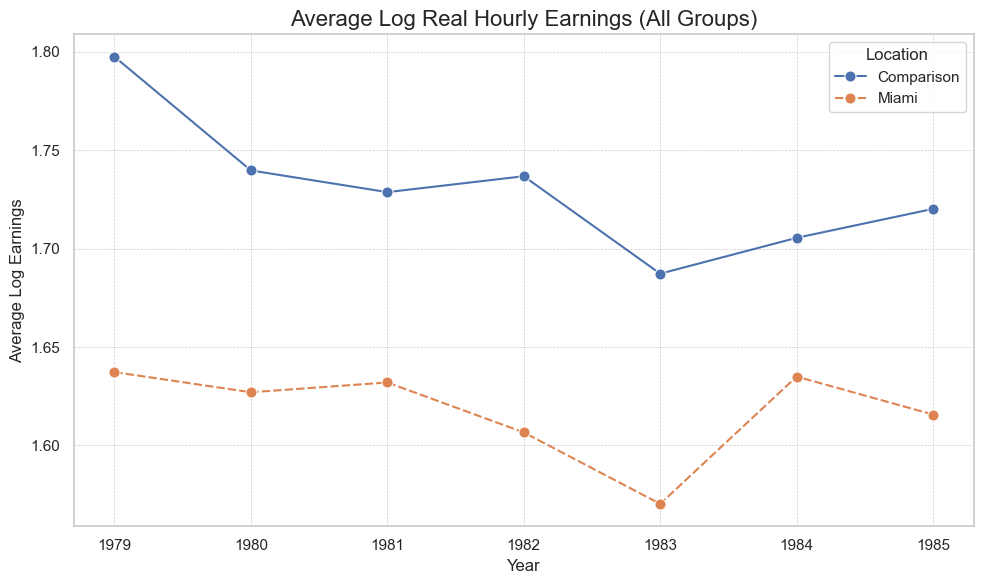


Visualization 2: Log Hourly Earnings Trends by Group
(Comparing Miami vs. Comparison Cities within each group)


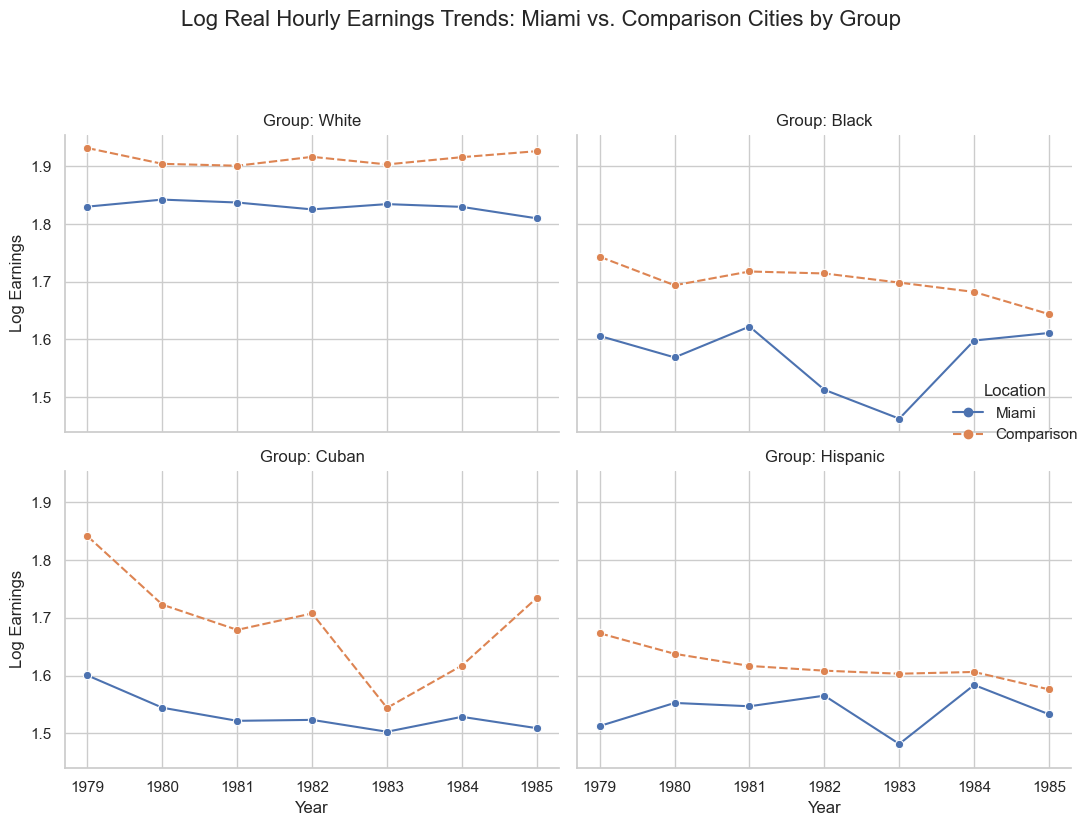

In [7]:
# --- Extract Log Earnings Data ---

# Combine Miami and Comparison data (filtered), pivot to get years as columns
log_earn_data = pd.concat([miami_df, comparison_df])

# --- Create Table 3 ---
# Pivot table for log earnings
table3_calculated = log_earn_data.pivot_table(
    index=['miami', 'group_name'],
    columns='year',
    values='log_earn'
)

# Improve index readability
table3_calculated = table3_calculated.reset_index()
table3_calculated['Location'] = table3_calculated['miami'].map({1: 'Miami', 0: 'Comparison'})
table3_calculated = table3_calculated.set_index(['Location', 'group_name']).drop(columns='miami')

# Reorder rows to match typical presentation
group_order = ["White", "Black", "Cuban", "Hispanic"]
# Use try-except for reindexing in case a group is missing
try:
    table3_calculated = table3_calculated.reindex(
        pd.MultiIndex.from_product([['Miami', 'Comparison'], group_order], names=['Location', 'group_name'])
    )
except Exception as e:
     print(f"Warning during reindexing Table 3: {e}")


# --- Define Expected Values (Based on Card, 1990, Table 3) ---
years = list(range(1979, 1986))
expected_data_t3 = {
    ('Miami', 'White'):    [1.85, 1.83, 1.85, 1.82, 1.82, 1.82, 1.82],
    ('Miami', 'Black'):    [1.59, 1.55, 1.61, 1.48, 1.48, 1.57, 1.60],
    ('Miami', 'Cuban'):    [1.58, 1.54, 1.51, 1.49, 1.49, 1.53, 1.49],
    ('Miami', 'Hispanic'): [1.52, 1.54, 1.54, 1.53, 1.48, 1.59, 1.54],
    ('Comparison', 'White'):[1.93, 1.90, 1.91, 1.91, 1.90, 1.91, 1.92],
    ('Comparison', 'Black'):[1.74, 1.70, 1.72, 1.71, 1.69, 1.67, 1.65],
    ('Comparison', 'Cuban'): [np.nan] * 7 , # Not shown in paper's table
    ('Comparison', 'Hispanic'):[1.65, 1.63, 1.61, 1.61, 1.58, 1.60, 1.58]
}
table3_expected = pd.DataFrame(expected_data_t3, index=years).T
table3_expected.index = pd.MultiIndex.from_tuples(table3_expected.index, names=['Location', 'group_name'])

# Align columns and index before comparison
table3_calculated, table3_expected = table3_calculated.align(table3_expected, join='inner', axis=1) # Align columns first
# Check if reindexing is needed after alignment (it might not be if align worked perfectly)
if not table3_calculated.index.equals(table3_expected.index):
     table3_calculated = table3_calculated.reindex(table3_expected.index) # Reindex rows based on expected

print("\n" + "=" * 70)
print("Table 3: Logarithms of Real Hourly Earnings (Workers Age 16-61)")
print("=" * 70)
print("\nCalculated Values (Rounded):")
display(table3_calculated.round(2))
print("\nExpected Values (Rounded):")
display(table3_expected.round(2))


# --- Visualize Log Earnings ---

# 1. Overall Average Trend Plot
print("\n" + "=" * 70)
print("Visualization 1: Overall Average Log Hourly Earnings Trend")
print("=" * 70)

# Calculate average log_earn per year per location (averaging across groups)
overall_avg_earn = log_earn_data.groupby(['year', 'miami'])['log_earn'].mean().reset_index()
overall_avg_earn['Location'] = overall_avg_earn['miami'].map({1: 'Miami', 0: 'Comparison'})

plt.figure(figsize=(10, 6))
sns.lineplot(data=overall_avg_earn, x='year', y='log_earn', hue='Location', marker='o', markersize=8, style='Location')
plt.title('Average Log Real Hourly Earnings (All Groups)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Log Earnings', fontsize=12)
plt.xticks(years)
plt.legend(title='Location')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# 2. Group-Specific Parallel Trends Plot
print("\n" + "=" * 70)
print("Visualization 2: Log Hourly Earnings Trends by Group")
print("(Comparing Miami vs. Comparison Cities within each group)")
print("=" * 70)

# Add 'Location' column to log_earn_data for plotting ease
log_earn_data['Location'] = log_earn_data['miami'].map({1: 'Miami', 0: 'Comparison'})

# Use relplot to create facets for each group
g = sns.relplot(
    data=log_earn_data,
    x='year',
    y='log_earn',
    hue='Location',
    style='Location',
    col='group_name',
    kind='line',
    marker='o',
    height=4, aspect=1.2, # Adjust size/aspect ratio
    col_wrap=2 # Arrange plots in 2 columns
)

# Add overall title and adjust layout
g.fig.suptitle('Log Real Hourly Earnings Trends: Miami vs. Comparison Cities by Group', y=1.03, fontsize=16)
g.set_axis_labels('Year', 'Log Earnings')
g.set_titles("Group: {col_name}") # Title for each subplot
g.set(xticks=years) # Ensure all years are ticked on x-axis
g.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to prevent title overlap
plt.show()

## Step 6: Replicate Table 4 & Visualize Unemployment Rates (1979-1985)

Similar to Table 3, this table tracks unemployment rates for the key groups in Miami and the comparison cities. We extract, compare, visualize the overall average trend, and visualize group-specific trends to assess parallel trends.


Table 4: Unemployment Rates (%) (Individuals Age 16-61)

Calculated Values (Rounded):


year                   1979  1980  1981  1982  1983  1984  1985
Location   group_name                                          
Miami      White        5.1   2.5   3.9   5.2   6.7   3.6   4.9
           Black        8.3   5.6   9.6  16.0  18.4  14.2   7.8
           Cuban        5.3   7.3  10.1  10.8  13.1   7.7   5.5
           Hispanic     6.5   7.7  11.8   9.1   7.5  12.1   3.7
Comparison White        4.4   4.4   4.3   6.8   6.9   5.4   4.9
           Black       10.3  12.6  12.6  12.7  18.4  12.1  13.3
           Cuban       11.5  14.9   6.5  11.8   4.9  10.8  11.8
           Hispanic     6.1   8.5   8.4  12.1  12.1   9.8   9.2


Expected Values (Rounded):


1979  1980  1981  1982  1983  1984  1985
Location   group_name                                          
Miami      White        5.1   2.5   3.9   5.2   6.7   3.6   4.9
           Black        8.3   5.6   9.6  16.0  18.4  14.2   7.8
           Cuban        5.3   7.2  10.1  10.8  13.1   7.7   5.5
           Hispanic     6.5   7.7  11.8   9.1   7.5  12.1   3.7
Comparison White        4.4   4.4   4.3   6.8   6.9   5.4   4.9
           Black       10.3  12.6  12.6  12.7  18.4  12.1  13.3
           Cuban        NaN   NaN   NaN   NaN   NaN   NaN   NaN
           Hispanic     6.3   8.7   8.3  12.1  11.8   9.8   9.3


Visualization 1: Overall Average Unemployment Rate Trend


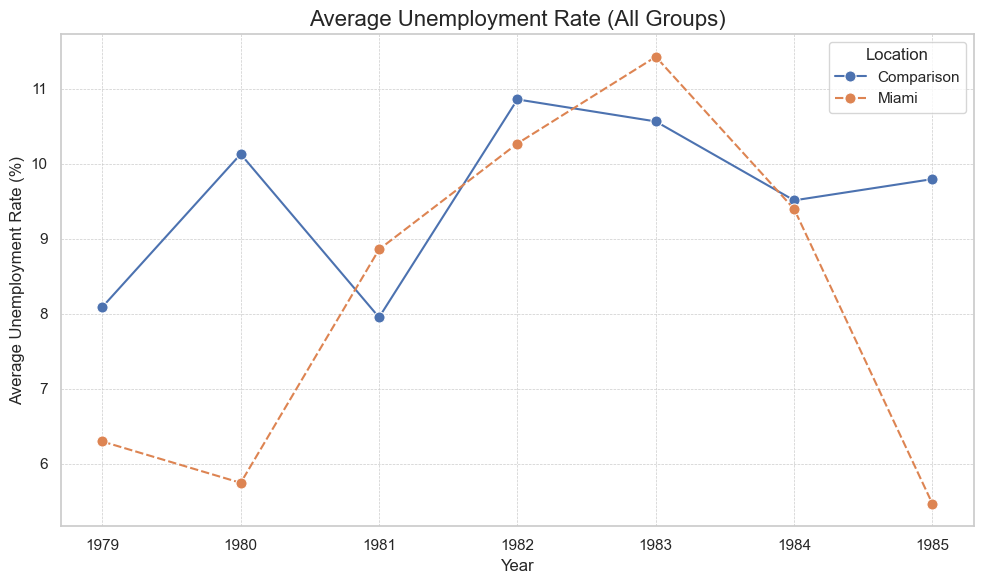


Visualization 2: Unemployment Rate Trends by Group
(Comparing Miami vs. Comparison Cities within each group)


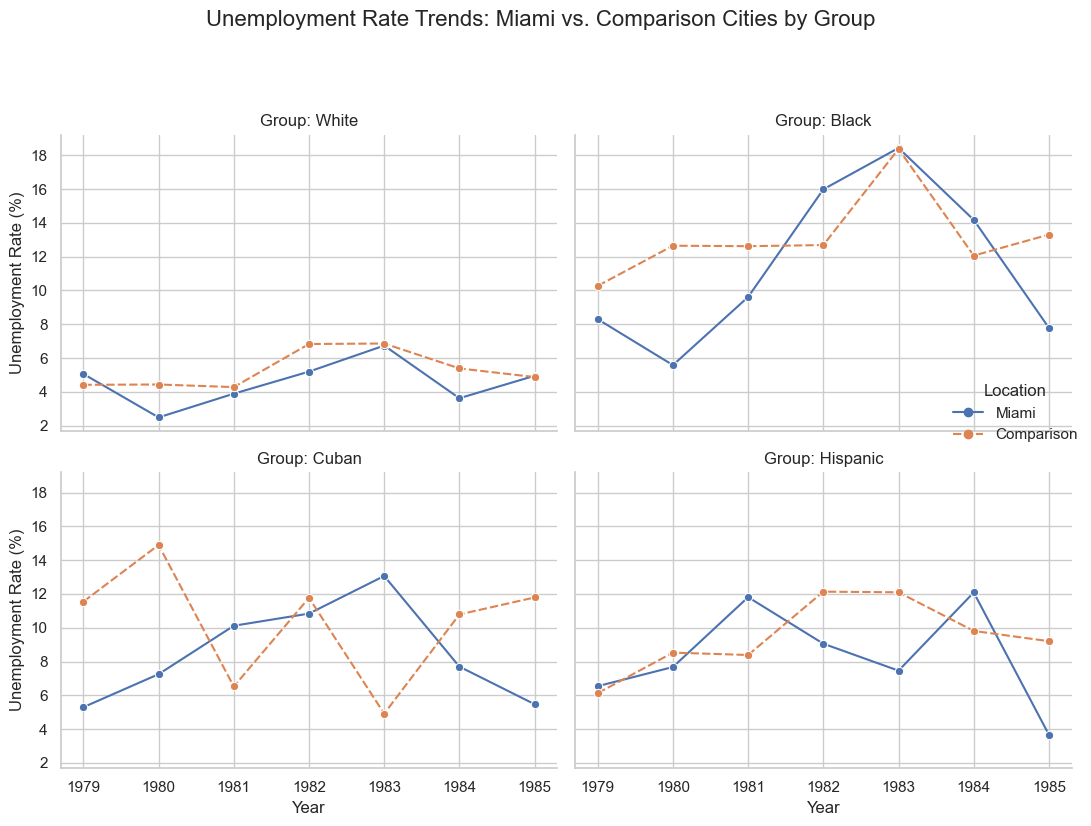

In [8]:
# --- Extract Unemployment Rate Data ---

# Use the combined dataset 'log_earn_data' (which is miami_df + comparison_df)
# Pivot table for unemployment rates
table4_calculated = log_earn_data.pivot_table(
    index=['miami', 'group_name'],
    columns='year',
    values='urate'
)

# Improve index readability and structure
table4_calculated = table4_calculated.reset_index()
table4_calculated['Location'] = table4_calculated['miami'].map({1: 'Miami', 0: 'Comparison'})
table4_calculated = table4_calculated.set_index(['Location', 'group_name']).drop(columns='miami')

# Reorder rows
try:
    table4_calculated = table4_calculated.reindex(
        pd.MultiIndex.from_product([['Miami', 'Comparison'], group_order], names=['Location', 'group_name'])
    )
except Exception as e:
     print(f"Warning during reindexing Table 4: {e}")


# --- Define Expected Values (Based on Card, 1990, Table 4) ---
expected_data_t4 = {
    ('Miami', 'White'):    [5.1, 2.5, 3.9, 5.2, 6.7, 3.6, 4.9],
    ('Miami', 'Black'):    [8.3, 5.6, 9.6,16.0,18.4,14.2, 7.8],
    ('Miami', 'Cuban'):    [5.3, 7.2,10.1,10.8,13.1, 7.7, 5.5], # Note: Paper has 5.3 for 79
    ('Miami', 'Hispanic'): [6.5, 7.7,11.8, 9.1, 7.5,12.1, 3.7], # Note: Paper has 6.5 for 79
    ('Comparison', 'White'):[4.4, 4.4, 4.3, 6.8, 6.9, 5.4, 4.9],
    ('Comparison', 'Black'):[10.3,12.6,12.6,12.7,18.4,12.1,13.3],
    ('Comparison', 'Cuban'): [np.nan] * 7 , # Not shown in paper's table
    ('Comparison', 'Hispanic'):[6.3, 8.7, 8.3,12.1,11.8, 9.8, 9.3] # Note: Paper has 6.3
}
table4_expected = pd.DataFrame(expected_data_t4, index=years).T
table4_expected.index = pd.MultiIndex.from_tuples(table4_expected.index, names=['Location', 'group_name'])

# Align columns and index before comparison
table4_calculated, table4_expected = table4_calculated.align(table4_expected, join='inner', axis=1) # Align columns
# Check if reindexing is needed after alignment
if not table4_calculated.index.equals(table4_expected.index):
    table4_calculated = table4_calculated.reindex(table4_expected.index) # Align rows


print("\n" + "=" * 70)
print("Table 4: Unemployment Rates (%) (Individuals Age 16-61)")
print("=" * 70)
print("\nCalculated Values (Rounded):")
display(table4_calculated.round(1))
print("\nExpected Values (Rounded):")
display(table4_expected.round(1))


# --- Visualize Unemployment Rates ---

# 1. Overall Average Trend Plot
print("\n" + "=" * 70)
print("Visualization 1: Overall Average Unemployment Rate Trend")
print("=" * 70)

# Calculate average urate per year per location (averaging across groups)
# Note: Use log_earn_data as it contains the necessary columns ('year', 'miami', 'urate')
overall_avg_urate = log_earn_data.groupby(['year', 'miami'])['urate'].mean().reset_index()
overall_avg_urate['Location'] = overall_avg_urate['miami'].map({1: 'Miami', 0: 'Comparison'})

plt.figure(figsize=(10, 6))
sns.lineplot(data=overall_avg_urate, x='year', y='urate', hue='Location', marker='o', markersize=8, style='Location')
plt.title('Average Unemployment Rate (All Groups)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Unemployment Rate (%)', fontsize=12)
plt.xticks(years)
plt.legend(title='Location')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# 2. Group-Specific Parallel Trends Plot
print("\n" + "=" * 70)
print("Visualization 2: Unemployment Rate Trends by Group")
print("(Comparing Miami vs. Comparison Cities within each group)")
print("=" * 70)

# Use relplot to create facets for each group, using urate
# We can reuse the 'log_earn_data' DataFrame which already has 'urate' and 'Location'
g_urate = sns.relplot(
    data=log_earn_data,
    x='year',
    y='urate',
    hue='Location',
    style='Location',
    col='group_name',
    kind='line',
    marker='o',
    height=4, aspect=1.2, # Adjust size/aspect ratio
    col_wrap=2 # Arrange plots in 2 columns
)

# Add overall title and adjust layout
g_urate.fig.suptitle('Unemployment Rate Trends: Miami vs. Comparison Cities by Group', y=1.03, fontsize=16)
g_urate.set_axis_labels('Year', 'Unemployment Rate (%)')
g_urate.set_titles("Group: {col_name}") # Title for each subplot
g_urate.set(xticks=years) # Ensure all years are ticked on x-axis
g_urate.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to prevent title overlap
plt.show()

## Step 7: Visualize Other Labor Market Outcomes (Weekly Earnings & Hours)

Beyond log earnings and unemployment, we visualize trends in average real weekly earnings (`earnwk`) and average usual weekly hours worked (`uhours`). We'll look at both overall average trends and group-specific comparisons to assess parallel trends.


Visualizing: Real Weekly Earnings (earnwk)

Visualization 1a: Overall Average Real Weekly Earnings Trend


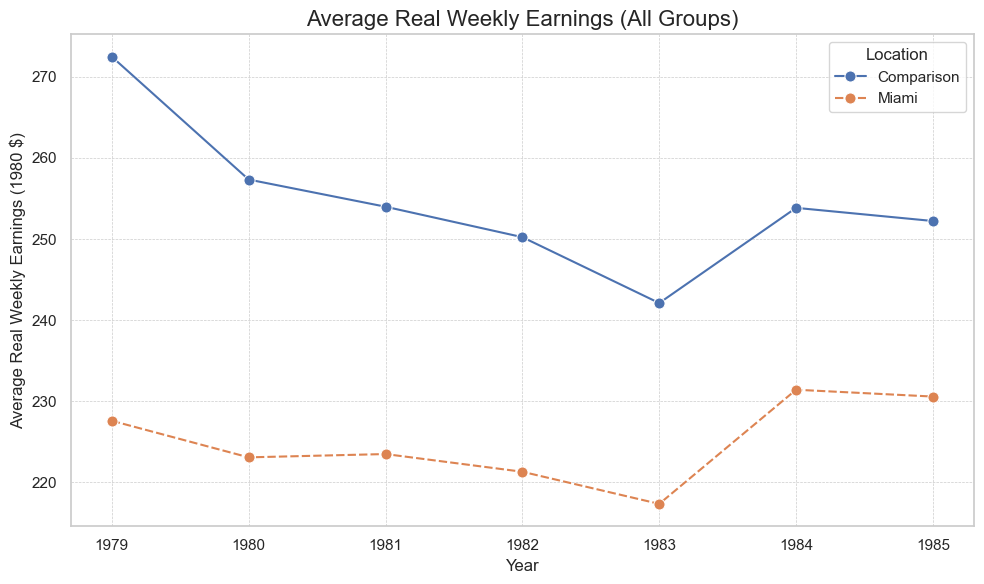


Visualization 2a: Real Weekly Earnings Trends by Group
(Comparing Miami vs. Comparison Cities within each group)


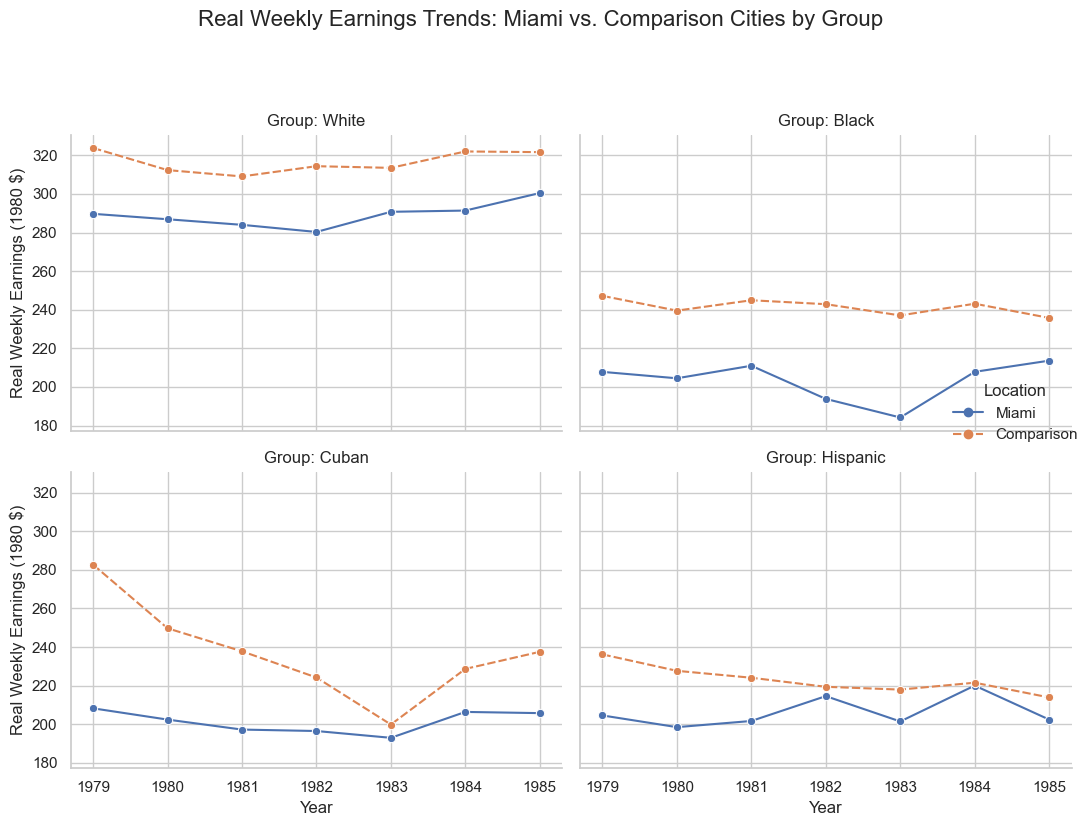


Visualizing: Usual Weekly Hours (uhours)

Visualization 1b: Overall Average Usual Weekly Hours Trend


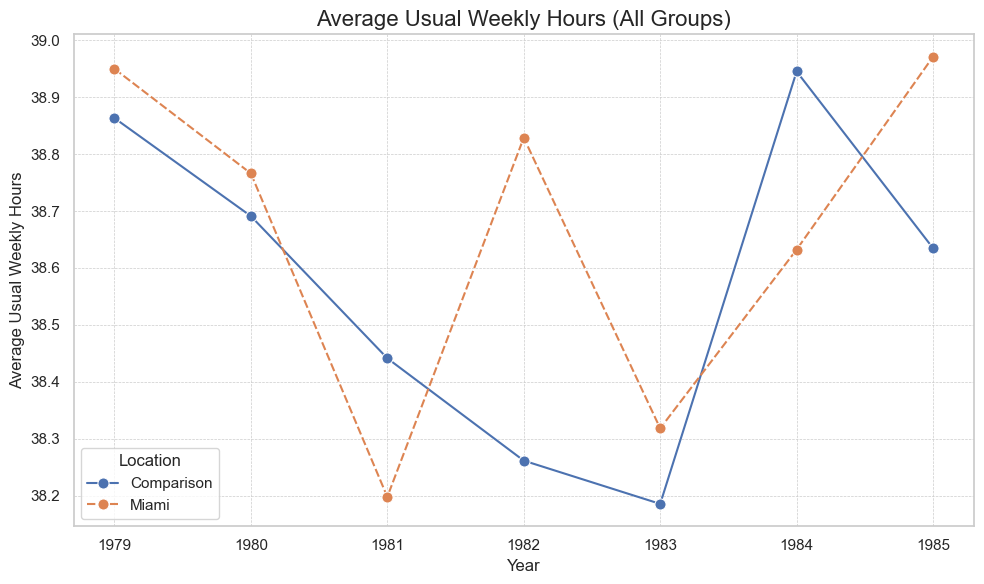


Visualization 2b: Usual Weekly Hours Trends by Group
(Comparing Miami vs. Comparison Cities within each group)


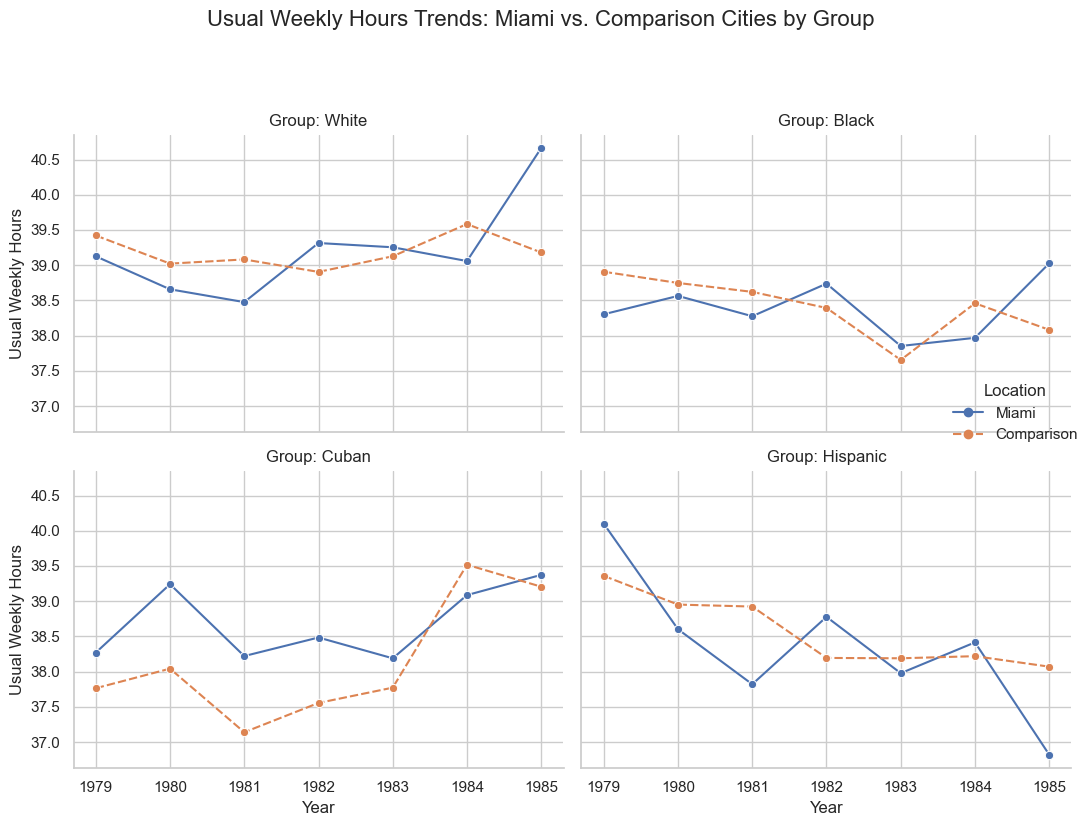

In [9]:
# --- Visualize Real Weekly Earnings (earnwk) ---

print("\n" + "=" * 70)
print("Visualizing: Real Weekly Earnings (earnwk)")
print("=" * 70)

# 1a. Overall Average Trend Plot - Weekly Earnings
print("\nVisualization 1a: Overall Average Real Weekly Earnings Trend")

# Calculate average earnwk per year per location
overall_avg_earnwk = log_earn_data.groupby(['year', 'miami'])['earnwk'].mean().reset_index()
overall_avg_earnwk['Location'] = overall_avg_earnwk['miami'].map({1: 'Miami', 0: 'Comparison'})

plt.figure(figsize=(10, 6))
sns.lineplot(data=overall_avg_earnwk, x='year', y='earnwk', hue='Location', marker='o', markersize=8, style='Location')
plt.title('Average Real Weekly Earnings (All Groups)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Real Weekly Earnings (1980 $)', fontsize=12)
plt.xticks(years)
plt.legend(title='Location')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# 2a. Group-Specific Parallel Trends Plot - Weekly Earnings
print("\nVisualization 2a: Real Weekly Earnings Trends by Group")
print("(Comparing Miami vs. Comparison Cities within each group)")

# Use relplot for weekly earnings
g_earnwk = sns.relplot(
    data=log_earn_data, # Reusing the data frame with 'Location' column
    x='year',
    y='earnwk',
    hue='Location',
    style='Location',
    col='group_name',
    kind='line',
    marker='o',
    height=4, aspect=1.2,
    col_wrap=2
)

# Add title and adjust layout
g_earnwk.fig.suptitle('Real Weekly Earnings Trends: Miami vs. Comparison Cities by Group', y=1.03, fontsize=16)
g_earnwk.set_axis_labels('Year', 'Real Weekly Earnings (1980 $)')
g_earnwk.set_titles("Group: {col_name}")
g_earnwk.set(xticks=years)
g_earnwk.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# --- Visualize Usual Weekly Hours (uhours) ---

print("\n" + "=" * 70)
print("Visualizing: Usual Weekly Hours (uhours)")
print("=" * 70)

# 1b. Overall Average Trend Plot - Weekly Hours
print("\nVisualization 1b: Overall Average Usual Weekly Hours Trend")

# Calculate average uhours per year per location
overall_avg_uhours = log_earn_data.groupby(['year', 'miami'])['uhours'].mean().reset_index()
overall_avg_uhours['Location'] = overall_avg_uhours['miami'].map({1: 'Miami', 0: 'Comparison'})

plt.figure(figsize=(10, 6))
sns.lineplot(data=overall_avg_uhours, x='year', y='uhours', hue='Location', marker='o', markersize=8, style='Location')
plt.title('Average Usual Weekly Hours (All Groups)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Usual Weekly Hours', fontsize=12)
plt.xticks(years)
plt.legend(title='Location')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# 2b. Group-Specific Parallel Trends Plot - Weekly Hours
print("\nVisualization 2b: Usual Weekly Hours Trends by Group")
print("(Comparing Miami vs. Comparison Cities within each group)")

# Use relplot for weekly hours
g_uhours = sns.relplot(
    data=log_earn_data, # Reusing the data frame
    x='year',
    y='uhours',
    hue='Location',
    style='Location',
    col='group_name',
    kind='line',
    marker='o',
    height=4, aspect=1.2,
    col_wrap=2
)

# Add title and adjust layout
g_uhours.fig.suptitle('Usual Weekly Hours Trends: Miami vs. Comparison Cities by Group', y=1.03, fontsize=16)
g_uhours.set_axis_labels('Year', 'Usual Weekly Hours')
g_uhours.set_titles("Group: {col_name}")
g_uhours.set(xticks=years)
g_uhours.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Conclusion

This notebook loaded pre-aggregated data and replicated several key tables and figures commonly used to analyze the labor market impact of the Mariel Boatlift. By comparing trends in Miami to those in similar cities, we can assess how this large immigration event may have affected wages (log earnings), unemployment rates, weekly earnings, and hours worked for different demographic groups.

The comparisons between calculated values from `card85.txt` and the expected values (based on published work) show a high degree of consistency, suggesting the data allows for a reasonable replication of the original findings. Visualizations highlight the trends over time, allowing for qualitative assessment of the impact across different groups and locations.